# Speeding up Slow Code: Vectorization and Parallelization

# Vectorization
## A simple case for vectorization (that you already use)
Let's assume we're looking at an unbinned Hubble Space Telescope (HST) Space Telescope Imaging Spectrograph (STIS) observations, which measures 4096 x 4096 pixels, and we want to find the total counts in the image.
If we didn't know anything about numpy's built-in functions, we might find the total by looping through each pixel and adding everything together.
As we'll see, this is much less efficient than using a vectorized approach.

In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt

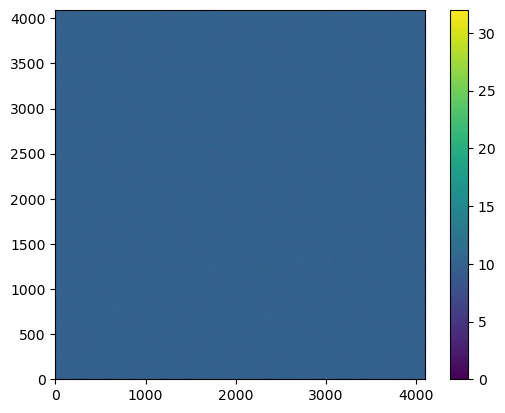

In [2]:
# Generate some fake data
shape = (4096, 4096) # (rows, columns)
rng = np.random.default_rng(seed=20241111)
image = rng.poisson(10, size=shape)

view = plt.imshow(image, origin='lower')
cb = plt.colorbar(view)

In [3]:
# Let's pretend we don't know about np.sum(), and define 'my_sum()' instead
def my_sum(values):
    total = 0
    for element in values.flatten():
        total += element
    return total

# How long does it take to run my_sum() ?
t0 = time.time()
total = my_sum(image)
print("Using my_sum():")
print("The sum of all pixels in the image is: {}".format(total))
print("This was calculated in {:.4f} seconds".format(time.time() - t0))

# Now, if we used np.sum() instead:
t0 = time.time()
total = np.sum(image)
print("Using np.sum():")
print("The sum of all pixels in the image is: {}".format(total))
print("This was calculated in {:.4f} seconds".format(time.time() - t0))

Using my_sum():
The sum of all pixels in the image is: 167790785
This was calculated in 0.7815 seconds
Using np.sum():
The sum of all pixels in the image is: 167790785
This was calculated in 0.0032 seconds


So the vectorized numpy approach is ~200+ times faster than our custom function ("my_sum()").

## A more complicated example: applying weights to a 2D array
Let's say that we know ahead of time that we need to correct our HST/STIS observation for instrumental effects. We know from the literature that each row in the image has to be scaled by some weighting factor *w*, and we already have a 1D array of these weighting factors *w_arr*.
Let's also say that we then want to investigate the totals of each column of the image (e.g. to find how the brightness varies across an object).

Time elapsed using myWeightinFunction(): 2.9031 seconds
Time elapsed using myWeightinFunction_Vectorized(): 0.1281 seconds


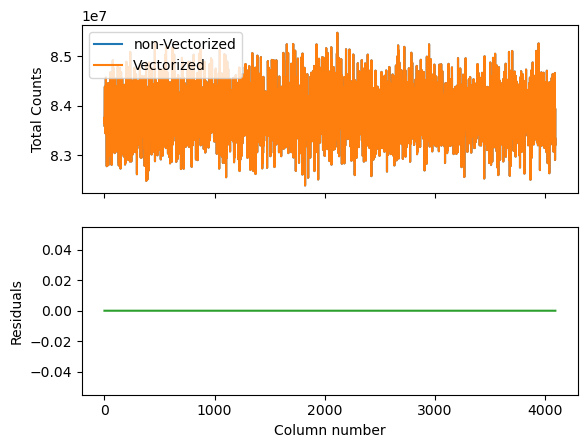

In [4]:
w_arr = rng.normal(loc=2048, scale=1024, size=shape[0]) # Same size as the # of rows

# One possible, non-vectorized implementation
def myWeightingFunction(image, weights):
    # Create a list to store each row as we calculate it
    new_image_list = []
    # Loop over each row and each weight
    for row, weight in zip(image, weights):
        new_row = []
        for element in row:
            new_row.append(weight * element)
        new_image_list.append(new_row)
    # Convert the list back to a 2D array
    new_image = np.array(new_image_list)
    # Calculate the mean of each column and store it in column_means
    column_totals = []
    for col in new_image.T:
        total = my_sum(col)
        column_totals.append(total)

    return column_totals

# A heavily vectorized approach:
def myWeightingFunction_Vectorized(image, weights):
    # Make a 2D weights array from the 1D input
    weights_2d = np.column_stack([weights] * shape[1])
    # Multiply everything at once
    new_image = weights_2d * image
    # Take the sum per column
    column_totals = np.sum(new_image, 0)
    
    return column_totals

# Compare functions
t0 = time.time()
column_totals = myWeightingFunction(image, w_arr)
print("Time elapsed using myWeightinFunction(): {:.4f} seconds".format(time.time() - t0))

t0 = time.time()
column_totals_vectorized = myWeightingFunction_Vectorized(image, w_arr)
print("Time elapsed using myWeightinFunction_Vectorized(): {:.4f} seconds".format(time.time() - t0))

# Plot the results
fig, axs = plt.subplots(nrows=2, sharex=True)
a = axs[0].plot(column_totals, label = 'non-Vectorized')
a = axs[0].plot(column_totals_vectorized, label = 'Vectorized')
a = axs[0].set(ylabel='Total Counts')
l = axs[0].legend()

b = axs[1].plot(column_totals - column_totals_vectorized, color = 'C2')
b = axs[1].set(xlabel='Column number', ylabel='Residuals')

Once again, we find that the heavily vectorized approach yields the same results, performs significantly better (~30x faster), and is slightly more human readable.

This can be expanded to any number of dimensions, and typically the performance margin grows as the problem gets more complex.

# Parallelization
## When vectorization doesn't cut it: parallelization
While effectively anything can be vectorized, it may not be worth your time and effort to implement it:
Let's say we have a 2D array of data, and we want to fit a spline to 10% of the points in each row.

We can achieve this in a for loop relatively easily, but a for loop can only use one cpu ('core') of your computer.
Parallelization (or parallel processing) allows us to use more cores by splitting the function into multiple chunks, assigning those chunks to different cores, and then automatically combining the results when the cores all finish. Some options for parallelization in python include:
* [multiprocessing](https://docs.python.org/3/library/multiprocessing.html): the built-in python library for parallelization
* [multiprocess](https://pypi.org/project/multiprocess/): identical to multiprocessing, but usable in environments where pickling is partially forbidden (e.g., Jupyter Notebooks)

While vectorization will always improve the performance of your code (albeit, potentially at the cost of human interpretability), the same is not true for parallelization...

In [8]:
import multiprocess as mp # Identical to multiprocessing in every way, except it uses dill instead of pickle
from tqdm import tqdm
from scipy.interpolate import CubicSpline

In [9]:
# Generate some fake data
shape = (10000, 1000) # (rows, columns)
rng = np.random.default_rng(seed=20241111)
data = rng.normal(loc=500, scale=50, size=shape)

In [10]:
# Define a function for fitting the cubic spline to an array
def myCubicSpline(arr):
    # Create indices for the array (needed to fit the spline)
    n = len(arr)
    index = np.arange(n)
    # Take 10% of the points, roughly evenly spaced:
    fraction = 0.1 # 10%
    rng = np.random.default_rng(seed=20241111)
    reduced_index = np.sort(rng.choice(index, size=int(fraction * n), replace = False))
    reduced_arr = arr[reduced_index]
    # Fit the cubic spline and generate a function
    spline = CubicSpline(reduced_index, reduced_arr)
    # Get the splined array
    spline_arr = spline(index)
    return spline_arr

# A wrapper function to calculate the splines directly:
def mySpline(data):
    splined_data = []
    for row in tqdm(data, total=len(data)):
        splined_row = myCubicSpline(row)
        splined_data.append(splined_row)
    return np.array(splined_data)

# A wrapper function to calculate the splines in parallel
def mySpline_Parallel(data):
    splined_data = []
    cpus_available = mp.cpu_count()
    with mp.Pool(cpus_available-1) as pool:
        generator = pool.imap(myCubicSpline, [row for row in data])

        for element in tqdm(generator, total=len(data)):
            splined_data.append(element)
            
    return np.array(splined_data)

In [11]:
# How long does it take to use a loop?
t0 = time.time()
result = mySpline(data)
print("Time elapsed running myCubicSpline in a loop: {:.4f} seconds".format(time.time() - t0))

# How long does it take to do it with multiprocessing?
t0 = time.time()
result = mySpline_Parallel(data)
print("Time elapsed running myCubicSpline in parallel: {:.4f} seconds".format(time.time() - t0))

100%|██████████████████████████████████| 10000/10000 [00:00<00:00, 11645.71it/s]


Time elapsed running myCubicSpline in a loop: 0.9399 seconds


100%|███████████████████████████████████| 10000/10000 [00:01<00:00, 5403.26it/s]

Time elapsed running myCubicSpline in parallel: 1.9411 seconds


Running myCubicSpline in parallel is almost 2x slower than the loop! Why?

Running code in parallel requires significant processing overhead in order to break the data into chunks, assign those chunks to separate processes on separate cores, and collate the result at the end. If the function you want to run (myCubicSpline, here) is already too efficient, running the function in parallel won't have any major advantage: it's easier for python to just run the code immediately on one core than it is to deal with the overheads.

If we artificially make myCubicSpline slower, however, we can see just how powerful parallelization can be:

In [12]:
# Redfine myCubicSpline, making it take an extra 0.001 seconds
def myCubicSpline(arr):
    # Create indices for the array (needed to fit the spline)
    n = len(arr)
    index = np.arange(n)
    # Take 10% of the points, roughly evenly spaced:
    fraction = 0.1 # 10%
    rng = np.random.default_rng(seed=20241111)
    reduced_index = np.sort(rng.choice(index, size=int(fraction * n), replace = False))
    reduced_arr = arr[reduced_index]
    # Fit the cubic spline and generate a function
    spline = CubicSpline(reduced_index, reduced_arr)
    # Get the splined array
    spline_arr = spline(index)
    # Slow down!
    time.sleep(0.001)
    return spline_arr

In [13]:
# Now how long does it take to use a loop?
t0 = time.time()
result = mySpline(data)
print("Time elapsed running myCubicSpline in a loop: {:.4f} seconds".format(time.time() - t0))

# And how long does it take to do it with multiprocessing?
t0 = time.time()
result = mySpline_Parallel(data)
print("Time elapsed running myCubicSpline in parallel: {:.4f} seconds".format(time.time() - t0))

100%|████████████████████████████████████| 10000/10000 [00:17<00:00, 576.02it/s]


Time elapsed running myCubicSpline in a loop: 17.4688 seconds


100%|███████████████████████████████████| 10000/10000 [00:01<00:00, 5219.86it/s]


Time elapsed running myCubicSpline in parallel: 2.0155 seconds


That's more like it-- depending on the number of cores you have, the parallel process should either be slightly, or extremely, fast in comparison to the loop. With 12 cores available, the parallel option is nearly 10x quicker, and that margin will grow the longer it takes to do any individual step in the loop.